# Train and run wflow_sbm surrogate model

The surrogate emulates Actual Evapotranspiration and Volumetric Water Content (top 10 cm) produced from Wflow_sbm over the Alpine region at 1 km spatial resolution and daily time steps. 

The repository offers a very small dataset in the demodata folder. Uncomment the jupyter notebook cell "DEMO" and comment the cell "ALPS" in order to train the model.

The figures at the end of the notebook show the surrogate outputs on the Alps, however the training data are not yet available to reproduce the results.

In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

import dask
from torch import nn

from hython.preprocess import apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, DataLoaderSpatialSampler
from hython.metrics import mse_metric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, missing_location_idx
from hython.models.lstm import CustomLSTM

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler


def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(43)

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Settings

In [9]:
wflow_model =  "alps1km_eobs" #

surrogate_experiment_name = "s0010" 

wd = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training")

surrogate_data = wd / f"{wflow_model}.zarr"

# path to directory to save model weights after training
dp_surrogate_model = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model")

dynamic_names = ["precip", "pet", "temp"] #  WFLOW forcings, input features of the surrogate
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] # WFLOW static parameters, input features of the surrogate
target_names = [ "vwc","actevap" ] # WFLOW outputs, targets of the surrogate


remove_lakes = True

# sampler for spatial training/validation
spatial_sampling = True
intervals = (4, 4) # every n km
train_origin = (0, 0)
val_origin = (2, 2)


# training/validation  period 
train_start = "2016-01-01"
train_end = "2018-12-31"

train_range = slice(train_start,train_end)

In [10]:
# Read from preprocessed data, select train range

# train
Xd = read_from_zarr(url=surrogate_data, group="xd", multi_index="gridcell").sel(time = train_range).xd
Xs = read_from_zarr(url=surrogate_data, group="xs", multi_index="gridcell").xs
Y = read_from_zarr(url=surrogate_data, group="y", multi_index="gridcell").sel(time = train_range).y

# other 
wflow_lakes = Xs.sel(feat="wflow_lakeareas").unstack()
wflow_dem = Xs.sel(feat="wflow_dem").unstack()

# select features and targets 
Xd = Xd.sel(feat=dynamic_names)
Xs = Xs.sel(feat=static_names)
Y = Y.sel(feat=target_names)

In [11]:
# read masks
mask_missing = read_from_zarr(url=surrogate_data, group="mask" ).mask
mask_lake = read_from_zarr(url=surrogate_data, group="mask_lake" ).mask_lake

In [12]:
spatial_batch_size = 256
temporal_sampling_size = 150 
seq_length = 360 
hidden_size = 24

model_params={
    "input_size": len(dynamic_names), 
    "hidden_size": hidden_size, 
    "output_size": len(target_names),
    "number_static_predictors": len(static_names), 

}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# Define the spatial samplers for both training and validation sets. Remeber the subsets should not overlap, so choose different origins.

if spatial_sampling:

    # training set
    spatial_train_sampler = RegularIntervalSampler(intervals = intervals, origin = train_origin)

    # validation set
    spatial_val_sampler = RegularIntervalSampler(intervals = intervals, origin = val_origin) 

    # Apply the samplers: return the cell indices that can be used later in training and validation to sample the whole spatial domain.
    data2d  = wflow_dem.values

    idx = missing_location_idx(Xs.values)
    
    sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, mask_missing)
    sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, mask_missing)

    # some useful metadata
    print(sampler_train_meta)

    # check location of training and validation sets
    #_ = plot_sampler(wflow_dem, sampler_train_meta, sampler_val_meta, figsize= (8, 8 ), markersize = 2)
else:
    idx = missing_location_idx(Xs)

    Xd_nomissing = Xd[~idx]
    Xs_nomissing = Xs[~idx]
    Y_nomissing = Y[~idx]

SamplerResult(
 - id_grid_2d: (689, 1177) 
 - idx_sampled_1d: (51035,) 
 - idx_sampled_1d_nomissing: (23740,)) 
 - idx_missing_1d: (431441,) 
 - sampled_grid_dims: (173, 295) 
 - xr_coords: None


In [14]:
print("Percentage of sampled data: ",(len(sampler_train_meta.idx_sampled_1d_nomissing)/ len(Xs[~idx].values.flatten()))*100, "%")

Percentage of sampled data:  1.0425669456213946 %


In [ ]:
# # Normalizing

if spatial_sampling:

    # statistics from training set
    _, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
    _, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
    _, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

    # normalize training set and validation set
    Xd = apply_normalization(Xd, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y = apply_normalization(Y, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()


else:
    _, d_m, d_std = apply_normalization(Xd_nomissing, type = "spacetime", how ='standard')
    _, s_m, s_std = apply_normalization(Xs_nomissing, type = "space", how ='standard')
    _, y_m, y_std = apply_normalization(Y_nomissing, type = "spacetime", how ='standard')

    Xd_nomissing = apply_normalization(Xd_nomissing, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs_nomissing = apply_normalization(Xs_nomissing, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y_nomissing = apply_normalization(Y_nomissing, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()

    Xd_test = apply_normalization(Xd_test, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs_test = apply_normalization(Xs_test, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y_test = apply_normalization(Y_test, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()

# Prepare Model inputs

In [10]:
if spatial_sampling:
    Xs = torch.Tensor(Xs.values)
    Xd = torch.Tensor(Xd.values)
    Y = torch.Tensor(Y.values)
    
    Xs.shape, Xd.shape, Y.shape

    # init datasets
    dataset = LSTMDataset(Xd, Y, Xs)
    
    train_sampler = DataLoaderSpatialSampler(dataset, num_samples=100, sampling_indices = sampler_train_meta.idx_sampled_1d_nomissing.tolist())
    valid_sampler = DataLoaderSpatialSampler(dataset, num_samples=100, sampling_indices = sampler_val_meta.idx_sampled_1d_nomissing.tolist())
    
    train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
    val_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = valid_sampler)
else:
    Xs_nms = torch.Tensor(Xs_nomissing)
    Xd_nms = torch.Tensor(Xd_nomissing)
    Y_nms = torch.Tensor(Y_nomissing)

    # init datasets
    dataset = LSTMDataset(Xd_nms, Y_nms, Xs_nms)
    
    train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=True)
    

# Initialize Model

In [11]:
model = CustomLSTM(model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=9, out_features=24, bias=True)
  (lstm): LSTM(24, 24, batch_first=True)
  (fc1): Linear(in_features=24, out_features=2, bias=True)
)

# Train/valid settings

In [12]:
path2models= "./checkpoints" 
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
opt = optim.Adam(model.parameters(), lr=1e-3)


loss_fn = RMSELoss(target_weight={"actevap":0.5, "vwc":0.5})

metric_fn = mse_metric

lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 90

In [13]:
params_train={
    "num_epochs": epochs,
    "temporal_sampling_idx_change_with_epoch": True,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names": target_names

}

# Run Train/valid

In [14]:
model, sm_loss_history, sm_metric_history = train_val(model, params_train)

Epoch 0/89, current lr=0.001
Copied best model weights!
train loss: 0.2780933380126953, train metric: {'vwc': 0.35171896, 'actevap': 0.26471767}
val loss: 0.2482599914073944, val metric: {'vwc': 0.30041435, 'actevap': 0.18144472}
----------
Epoch 1/89, current lr=0.001
Copied best model weights!
train loss: 0.2249985933303833, train metric: {'vwc': 0.23402806, 'actevap': 0.15164687}
val loss: 0.23778560757637024, val metric: {'vwc': 0.26476702, 'actevap': 0.15935016}
----------
Epoch 2/89, current lr=0.001
train loss: 0.2279016226530075, train metric: {'vwc': 0.21803096, 'actevap': 0.17277324}
val loss: 0.24749356508255005, val metric: {'vwc': 0.2571887, 'actevap': 0.19891822}
----------
Epoch 3/89, current lr=0.001
Copied best model weights!
train loss: 0.20539984107017517, train metric: {'vwc': 0.2177966, 'actevap': 0.11192251}
val loss: 0.22192984819412231, val metric: {'vwc': 0.24678573, 'actevap': 0.13336411}
----------
Epoch 4/89, current lr=0.001
train loss: 0.2016674429178238, 

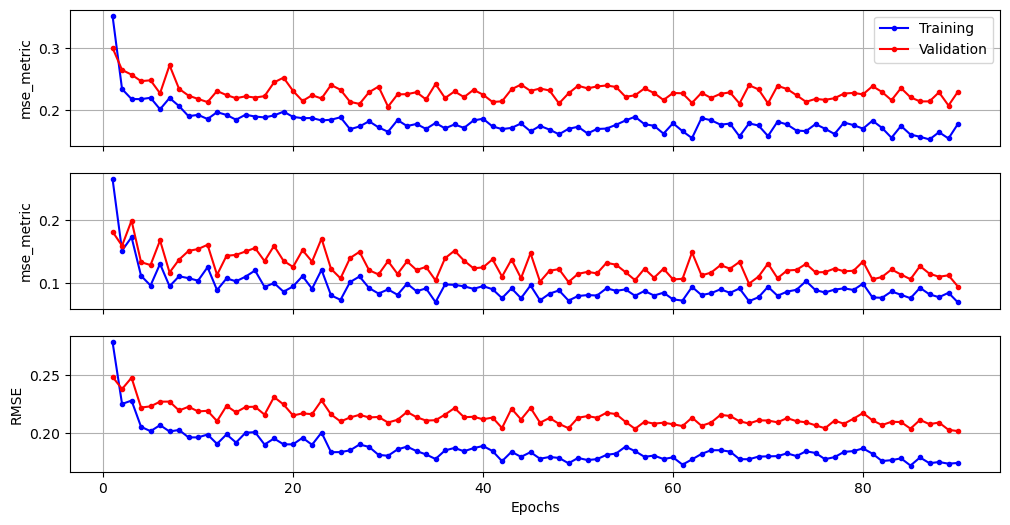

In [17]:
lepochs = list(range(1,params_train["num_epochs"] + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, sm_metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, sm_metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[0].set_ylabel(metric_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, sm_metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, sm_metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[1].set_ylabel(metric_fn.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)

In [19]:
# save model
fp = dp_surrogate_model / f"{wflow_model}_{surrogate_experiment_name}.pt"

torch.save(model.state_dict(), fp)